In [1]:
from sklearn.datasets import load_files
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize,maxabs_scale,robust_scale,StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score,KFold,GridSearchCV,train_test_split,StratifiedKFold,cross_val_predict
from sklearn.ensemble import GradientBoostingClassifier

from scipy import stats
from scipy import interp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import *

# Préparation des données

In [2]:
aaa = pd.read_csv('atis.test.csv2',header=None,sep='\t')
aaa

0    1    2
0     i i O O 1.0 0.9999962 0.99848515 0.77888465 0....   AC   AC
1     would would O O 1.0 0.9998754 0.99947673 0.915...   AC   AC
2     like like O O 1.0 0.9999945 0.99995065 0.84418...   AC   AC
3     to to O O 1.0 0.9999969 0.9999987 0.68386316 0...   AC   AC
4     find find O O 1.0 0.9999758 0.98818725 0.99477...   AC   AC
...                                                 ...  ...  ...
9221  from from O O 1.0 0.9851248 0.9547248 0.999996...   AC   AC
9222  memphis city_name B-fromloc.city_name B-fromlo...   NC   AC
9223  to to O O 1.0 0.99999785 0.9999995 0.8097399 0...   AC   AC
9224  tacoma city_name B-toloc.city_name B-toloc.cit...   NC   AC
9225                                                NaN  NaN  NaN

[9226 rows x 3 columns]

In [3]:
atis_test = pd.read_csv('atis.test.csv2',header=None,sep='\t')
atis_test = atis_test.rename(columns = {2 : 'ac_nc'})
temp = pd.DataFrame(index=range(atis_test.shape[0]),columns = range(len(atis_test.iloc[1,0].split(" "))-1))
ac_nc = atis_test.iloc[:,2]     
for i in range(atis_test.shape[0]):
    if not isinstance(atis_test.iloc[i,0], float):
         temp.iloc[i,:] = atis_test.iloc[i,0].split(" ")[:-1]
atis_test = pd.concat([temp,ac_nc],axis=1)

In [4]:
#Passage au float 
for i in range(4,105):
    atis_test.iloc[:,i] = pd.to_numeric(atis_test.iloc[:,i], downcast="float")

atis_test = atis_test.dropna(axis = 0)
atis_test = atis_test.set_index(np.arange(len(atis_test.index)))

In [5]:
atis_test

0          1                    2                    3         4  \
0           i          i                    O                    O  1.000000   
1       would      would                    O                    O  1.000000   
2        like       like                    O                    O  1.000000   
3          to         to                    O                    O  1.000000   
4        find       find                    O                    O  1.000000   
...       ...        ...                  ...                  ...       ...   
8328    flies      flies                    O                    O  1.000000   
8329     from       from                    O                    O  1.000000   
8330  memphis  city_name  B-fromloc.city_name  B-fromloc.city_name  1.000000   
8331       to         to                    O                    O  1.000000   
8332   tacoma  city_name    B-toloc.city_name    B-toloc.city_name  0.999951   

             5         6             7         8         9  ...            96  \
0     0.999996  0.998485  7.788846e-01  0.999940  0.002049  ...  2.283921e-04   
1     0.999875  0.999477  9.154309e-01  0.999487  0.005721  ...  9.156407e-06   
2     0.999995  0.999951  8.441816e-01  0.999974  0.005603  ...  2.209583e-04   
3     0.999997  0.999999  6.838632e-01  0.999996  0.000349  ...  3.388961e-04   
4     0.999976  0.988187  9.947737e-01  0.999447  0.000005  ...  5.328328e-04   
...        ...       ...           ...       ...       ...  ...           ...   
8328  0.998161  0.990042  9.984016e-01  0.995982  0.001721  ...  3.316205e-03   
8329  0.985125  0.954725  9.999968e-01  0.999732  0.022469  ...  3.347058e-08   
8330  0.999676  1.000000  9.999970e-01  1.000000  0.999997  ...  2.993399e-06   
8331  0.999998  1.000000  8.097399e-01  1.000000  0.020385  ...  7.529587e-05   
8332  0.999878  1.000000  1.918442e-07  0.999346  0.000001  ...  9.995607e-01   

                97        98            99       100       101           102  \
0     6.030280e-06  0.999974  7.158415e-03  0.997813  0.999928  9.963375e-01   
1     6.410691e-07  0.999574  1.848402e-03  0.998985  0.999605  9.999663e-01   
2     3.344390e-06  0.999993  2.884592e-05  0.999939  0.999946  9.999613e-01   
3     9.697965e-05  0.999994  1.462526e-06  0.999951  0.999990  9.999543e-01   
4     6.339534e-08  0.999304  4.498134e-03  0.999238  0.999704  9.976879e-01   
...            ...       ...           ...       ...       ...           ...   
8328  3.012199e-06  0.998238  5.529481e-02  0.992015  0.998788  9.985346e-01   
8329  1.321428e-06  0.987112  2.650122e-01  0.999868  0.999901  9.999970e-01   
8330  9.997147e-01  0.999991  2.062584e-05  1.000000  0.999999  9.997613e-01   
8331  3.186049e-04  0.999999  2.669254e-07  0.999976  0.999999  9.999964e-01   
8332  9.999809e-01  0.998701  9.599132e-06  0.996473  0.999762  1.595826e-08   

               103       104  ac_nc  
0     9.974450e-01  0.000051     AC  
1     9.999892e-01  0.000620     AC  
2     9.999884e-01  0.000097     AC  
3     9.999862e-01  0.000023     AC  
4     9.987430e-01  0.000004     AC  
...            ...       ...    ...  
8328  9.999887e-01  0.000243     AC  
8329  9.999999e-01  0.004105     AC  
8330  9.999977e-01  0.999089     AC  
8331  9.999977e-01  0.000026     AC  
8332  3.488452e-07  0.000018     AC  

[8333 rows x 106 columns]

In [6]:
media_test = pd.read_csv('media.test.csv2',header=None,sep='\t')
media_test = media_test.rename(columns = {4 : 'ac_nc'})

In [7]:
temp = pd.DataFrame(index=range(media_test.shape[0]),columns = range(len(media_test.iloc[5,2].split(" "))-1))
temp  
for i in range(media_test.shape[0]):
    if not isinstance(media_test.iloc[i,2], float):
         temp.iloc[i,:] = media_test.iloc[i,2].split(" ")[:-1]

media_test = pd.concat([media_test.iloc[:,0:2],temp,media_test['ac_nc']],axis = 1)
#Passage au float 
for i in range(4,105):
    media_test.iloc[:,i] = pd.to_numeric(media_test.iloc[:,i], downcast="float")

media_test = media_test.dropna(axis = 0)
media_test = media_test.set_index(np.arange(len(media_test.index)))

In [8]:
media_test

0          1                     0                     1  \
0             je         je       B-command-tache       B-command-tache   
1       voudrais   voudrais       I-command-tache       I-command-tache   
2       réserver   réserver       I-command-tache       I-command-tache   
3           pour       pour          B-rang-temps          B-rang-temps   
4             le         le          I-rang-temps          I-rang-temps   
...          ...        ...                   ...                   ...   
25972  connexion  connexion  I-chambre-equipement  I-chambre-equipement   
25973   internet      EQUIP  I-chambre-equipement  I-chambre-equipement   
25974        oui        oui             B-reponse             B-reponse   
25975        non        non             B-reponse             B-reponse   
25976      merci      merci                     O                     O   

              2            3            4            5            6  \
0      0.998018    0.0301482  0.000228925      0.95256       0.1821   
1      0.999604    0.0073296  0.000770102      0.85728     0.179354   
2      0.999715   0.00572529  0.000175758     0.960663     0.287657   
3      0.996765     0.973825    0.0532127    0.0382341     0.963447   
4      0.993861     0.990773  0.000549251    0.0560375  6.60816e-05   
...         ...          ...          ...          ...          ...   
25972  0.997337     0.999366     0.958398   0.00717638  0.000711134   
25973  0.998073     0.999054     0.631952   0.00793344  0.000436496   
25974  0.999201  0.000383502  0.000792989     0.979959      0.99991   
25975  0.999327  0.000378273  0.000161412     0.985691     0.997319   
25976  0.999999     0.687728     0.997026  0.000145167     0.999192   

                 7  ...           94           95           96           97  \
0        0.0480406  ...     0.813737  0.000333157  0.000366783  0.000233999   
1         0.631231  ...      0.83518     0.995363  0.000259368  2.41359e-07   
2         0.926826  ...      0.97941     0.986365  0.000136052  2.90215e-06   
3         0.015918  ...     0.265613     0.887438  1.70981e-06  0.000461083   
4         0.708674  ...     0.941017     0.956745  4.16158e-06  1.56448e-06   
...            ...  ...          ...          ...          ...          ...   
25972    0.0035486  ...        0.802    0.0440583  1.80593e-05  2.92048e-05   
25973  0.000958828  ...     0.858877   0.00202038  1.44854e-05  2.24003e-05   
25974  4.38209e-05  ...  0.000511339  5.48497e-05  1.68043e-05     0.313139   
25975  0.000293395  ...   0.00417137  1.66618e-05  3.08434e-05     0.660996   
25976  0.000201005  ...  5.30048e-05     0.475639  1.69593e-05  9.62638e-05   

                98           99          100          101          102 ac_nc  
0         0.985451  4.95932e-05  6.24909e-05     0.231074  2.02805e-05    AC  
1          0.99212  5.81254e-06  6.22006e-05   0.00100287  0.000151936    AC  
2         0.999223  1.49754e-05  1.14268e-05  5.52364e-05  4.52373e-05    AC  
3         0.935826  1.94494e-05  0.000271944   0.00582158   0.00127766    AC  
4         0.753173   6.4256e-06  0.000186329  0.000904377   0.00360909    AC  
...            ...          ...          ...          ...          ...   ...  
25972    0.0022361  3.73248e-06      0.97818     0.905776     0.999124    AC  
25973  0.000472328  4.81788e-06     0.708476     0.653963     0.996315    NC  
25974     0.921367  1.13104e-05      0.99984      0.99986   0.00013701    AC  
25975     0.970992  2.22921e-05     0.982955     0.983058  9.19438e-05    AC  
25976    0.0181047  5.35363e-06     0.965527     0.999829      0.99079    AC  

[25977 rows x 106 columns]

# Qualité des prédictions

## Mesures

In [9]:
true_classes_atis = [1 if atis_test.iloc[i,2]==atis_test.iloc[i,3] else 0 for i in range(len(atis_test.index))]
true_classes_media = [1 if media_test.iloc[i,2]== media_test.iloc[i,3] else 0 for i in range(len(media_test.index))]

In [10]:
print(classification_report(atis_test.iloc[:,2],atis_test.iloc[:,3]))

/Users/malotanne/opt/anaconda3/envs/TestKeras/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/malotanne/opt/anaconda3/envs/TestKeras/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                              precision    recall  f1-score   support

             B-aircraft_code       1.00      0.76      0.86        33
              B-airline_code       0.91      0.94      0.93        34
              B-airline_name       1.00      0.98      0.99       101
              B-airport_code       0.00      0.00      0.00         9
              B-airport_name       1.00      0.19      0.32        21
 B-arrive_date.date_relative       1.00      1.00      1.00         2
      B-arrive_date.day_name       0.79      1.00      0.88        11
    B-arrive_date.day_number       0.71      0.83      0.77         6
    B-arrive_date.month_name       0.71      0.83      0.77         6
      B-arrive_time.end_time       0.88      0.88      0.88         8
 B-arrive_time.period_of_day       0.67      1.00      0.80         6
    B-arrive_time.start_time       0.88      0.88      0.88         8
          B-arrive_time.time       0.89      0.97      0.93        34
 B-arrive_time.time

/Users/malotanne/opt/anaconda3/envs/TestKeras/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/malotanne/opt/anaconda3/envs/TestKeras/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/malotanne/opt/anaconda3/envs/TestKeras/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

## Courbe ROC

AUC RNN = 0.9077
AUC RNN = 0.8440


Text(0, 0.5, 'True positive rate')

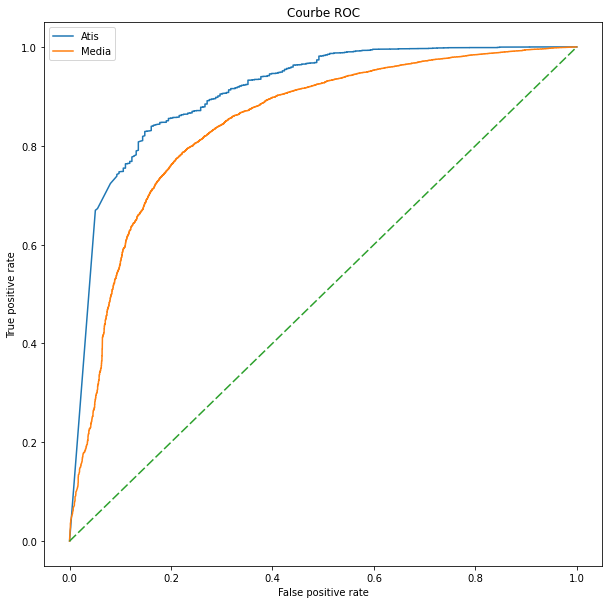

In [11]:
fpr, tpr, thresholds = metrics.roc_curve(true_classes_atis, atis_test.iloc[:,4],pos_label=1)
fpr2, tpr2, thresholds2 = metrics.roc_curve(true_classes_media, media_test.iloc[:,4],pos_label=1)
print('AUC RNN = {:.4f}'.format(roc_auc_score(true_classes_atis, atis_test.iloc[:,4])))
print('AUC RNN = {:.4f}'.format(roc_auc_score(true_classes_media, media_test.iloc[:,4])))
figure = plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.plot(fpr2, tpr2)
plt.plot(np.arange(0,1.02,0.02),np.arange(0,1.02,0.02), dashes=[6, 2])
title = 'Courbe ROC'
plt.title(title) 
plt.legend(['Atis','Media'])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

#### Corpus ATIS pour les 3 mesures

## Courbe Rappel-Précision

Text(0, 0.5, 'Précision')

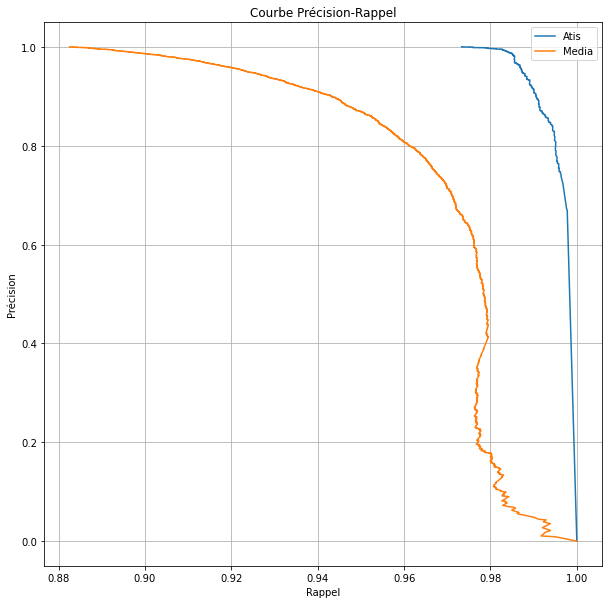

In [12]:
fpr, tpr, thresholds = metrics.precision_recall_curve(true_classes_atis, atis_test.iloc[:,4],pos_label=1)
fpr2, tpr2, thresholds2 = metrics.precision_recall_curve(true_classes_media, media_test.iloc[:,4],pos_label=1)
figure = plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.plot(fpr2, tpr2)
title = 'Courbe Précision-Rappel'
plt.title(title) 
plt.xlabel('Rappel')
plt.grid()
plt.legend(['Atis','Media'])
plt.ylabel('Précision')

# Objectif

Notre objectif est d'obtenir des mesures sur la distribution des composantes du vecteur de l'espace latent, notamment afin de classifier les mots dans l'un des 4 clusters AC,AE,NC et NE.

In [13]:
X = np.array(atis_test.iloc[:,5:105])
X

array([[9.9999619e-01, 9.9848515e-01, 7.7888465e-01, ..., 9.9633753e-01,
        9.9744499e-01, 5.1191655e-05],
       [9.9987543e-01, 9.9947673e-01, 9.1543090e-01, ..., 9.9996626e-01,
        9.9998915e-01, 6.2040781e-04],
       [9.9999452e-01, 9.9995065e-01, 8.4418160e-01, ..., 9.9996126e-01,
        9.9998844e-01, 9.7025892e-05],
       ...,
       [9.9967623e-01, 1.0000000e+00, 9.9999702e-01, ..., 9.9976128e-01,
        9.9999774e-01, 9.9908948e-01],
       [9.9999785e-01, 9.9999952e-01, 8.0973989e-01, ..., 9.9999642e-01,
        9.9999774e-01, 2.6148715e-05],
       [9.9987805e-01, 1.0000000e+00, 1.9184415e-07, ..., 1.5958264e-08,
        3.4884525e-07, 1.7850398e-05]], dtype=float32)

On a des densités pour 2 cas : si on suppose l'indépendance des v.a. ou si l'on donne la densité conjointe

In [14]:
def kde_sklearn(x,kernel, bandwidth=1,**kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, kernel=kernel,**kwargs)
    kde_skl.fit(x)
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x)
    return log_pdf

In [15]:
dico_densite_ATIS = {}
for i in range(100) : 
    print('Densité {}'.format(i))
    grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 1, 7)},
                    cv=5) # 5-fold cross-validation
    x = X[:,i].reshape(-1, 1)
    grid.fit(x)
    dico_densite_ATIS[i]= kde_sklearn(x,'gaussian', grid.best_params_['bandwidth'])  

Densité 0
Densité 1
Densité 2
Densité 3
Densité 4
Densité 5
Densité 6
Densité 7
Densité 8
Densité 9
Densité 10
Densité 11
Densité 12
Densité 13
Densité 14
Densité 15
Densité 16
Densité 17
Densité 18
Densité 19
Densité 20
Densité 21
Densité 22
Densité 23
Densité 24
Densité 25
Densité 26
Densité 27
Densité 28
Densité 29
Densité 30
Densité 31
Densité 32
Densité 33
Densité 34
Densité 35
Densité 36
Densité 37
Densité 38
Densité 39
Densité 40
Densité 41
Densité 42
Densité 43
Densité 44
Densité 45
Densité 46
Densité 47
Densité 48
Densité 49
Densité 50
Densité 51
Densité 52
Densité 53
Densité 54
Densité 55
Densité 56
Densité 57
Densité 58
Densité 59
Densité 60
Densité 61
Densité 62
Densité 63
Densité 64
Densité 65
Densité 66
Densité 67
Densité 68
Densité 69
Densité 70
Densité 71
Densité 72
Densité 73
Densité 74
Densité 75
Densité 76
Densité 77
Densité 78
Densité 79
Densité 80
Densité 81
Densité 82
Densité 83
Densité 84
Densité 85
Densité 86
Densité 87
Densité 88
Densité 89
Densité 90
Densité 9

In [ ]:
X_media = np.array(media_test.iloc[:,5:105])
dico_densite_MEDIA = {}
for i in range(100) : 
    print('Densité {}'.format(i))
    grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 1, 7)},
                    cv=5) # 5-fold cross-validation
    x = X_media[:,i].reshape(-1, 1)
    grid.fit(x)
    dico_densite_MEDIA[i]= kde_sklearn(x,'gaussian', grid.best_params_['bandwidth'])

Densité 0
Densité 1
Densité 2
Densité 3
Densité 4
Densité 5
Densité 6
Densité 7
Densité 8
Densité 9
Densité 10
Densité 11
Densité 12
Densité 13
Densité 14
Densité 15
Densité 16
Densité 17
Densité 18
Densité 19
Densité 20
Densité 21
Densité 22
Densité 23
Densité 24
Densité 25
Densité 26
Densité 27
Densité 28
Densité 29
Densité 30
Densité 31
Densité 32
Densité 33


On calcule donc la somme de log-prob

In [ ]:
densite_ATIS_inde = []
for i in range(len(atis_test.index)):
     densite_ATIS_inde.append(0)
for i in range(len(atis_test.index)):
    for j in range(100):
        densite_ATIS_inde[i] = densite_ATIS_inde[i] + dico_densite_ATIS[j][i] 

In [ ]:
densite_MEDIA_inde = []
for i in range(len(media_test.index)):
     densite_MEDIA_inde.append(0)
for i in range(len(media_test.index)):
    for j in range(100):
        densite_MEDIA_inde[i] = densite_MEDIA_inde[i] + dico_densite_MEDIA[j][i] 

Dans le cas indépendant : 

In [ ]:
X = np.array(atis_test.iloc[:,5:105])

grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 1, 7)},
                    cv=5) # 5-fold cross-validation
grid.fit(X)

print(grid.best_params_)

kde = KernelDensity(bandwidth= grid.best_params_['bandwidth'],kernel='gaussian')
kde.fit(X)

densite_non_inde_ATIS = kde.score_samples(X[:X.shape[0]])

In [ ]:
X = np.array(media_test.iloc[:,5:105])

grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 1, 7)},
                    cv=5) # 5-fold cross-validation
grid.fit(X)

print(grid.best_params_)

kde = KernelDensity(bandwidth= grid.best_params_['bandwidth'],kernel='gaussian')
kde.fit(X)

densite_non_inde_MEDIA = kde.score_samples(X[:X.shape[0]])

In [ ]:
X = np.array(media_test.iloc[:,5:105])

grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 1, 7)},
                    cv=5) # 5-fold cross-validation
grid.fit(X)

print(grid.best_params_)

kde = KernelDensity(bandwidth= grid.best_params_['bandwidth'],kernel='gaussian')
kde.fit(X)

densite_ATIS_non_inde = kde.score_samples(X[:X.shape[0]])

### Courbe ROC avec nos nouveaux scores

##### ATIS

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(true_classes_atis, atis_test.iloc[:,4],pos_label=1)
fpr2, tpr2, thresholds2 = metrics.roc_curve(true_classes_atis, densite_ATIS_inde,pos_label=1)
fpr3, tpr3, thresholds3 = metrics.roc_curve(true_classes_atis, densite_non_inde_ATIS,pos_label=1)


print('AUC RNN = {:.4f}'.format(roc_auc_score(true_classes_atis, atis_test.iloc[:,4])))
print('AUC RNN = {:.4f}'.format(roc_auc_score(true_classes_atis, densite_ATIS_inde)))
print('AUC RNN = {:.4f}'.format(roc_auc_score(true_classes_atis, densite_non_inde_ATIS)))
figure = plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.plot(fpr2, tpr2)
plt.plot(fpr3, tpr3)
plt.plot(np.arange(0,1.02,0.02),np.arange(0,1.02,0.02), dashes=[6, 2])
title = 'Courbe ROC'
plt.title(title) 
plt.legend(['LSTM','Densité Indépendante','Densité conjointe'])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

##### MEDIA

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(true_classes_media, media_test.iloc[:,4],pos_label=1)
fpr2, tpr2, thresholds2 = metrics.roc_curve(true_classes_media, densite_MEDIA_inde,pos_label=1)
fpr3, tpr3, thresholds3 = metrics.roc_curve(true_classes_media, densite_non_inde_MEDIA,pos_label=1)


print('AUC RNN = {:.4f}'.format(roc_auc_score(true_classes_media, media_test.iloc[:,4])))
print('AUC RNN = {:.4f}'.format(roc_auc_score(true_classes_media, densite_MEDIA_inde)))
print('AUC RNN = {:.4f}'.format(roc_auc_score(true_classes_media, densite_non_inde_MEDIA)))
figure = plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.plot(fpr2, tpr2)
plt.plot(fpr3, tpr3)
plt.plot(np.arange(0,1.02,0.02),np.arange(0,1.02,0.02), dashes=[6, 2])
title = 'Courbe ROC'
plt.title(title) 
plt.legend(['LSTM','Densité Indépendante','Densité conjointe'])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

### Courbe Rappel-Précision avec nouveaux scores

##### ATIS

In [ ]:
fpr, tpr, thresholds = metrics.precision_recall_curve(true_classes_atis, atis_test.iloc[:,4],pos_label=1)
fpr2, tpr2, thresholds2 = metrics.precision_recall_curve(true_classes_atis, densite_ATIS_inde,pos_label=1)
fpr3, tpr3, thresholds3 = metrics.precision_recall_curve(true_classes_atis, densite_non_inde_ATIS,pos_label=1)


figure = plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.plot(fpr2, tpr2)
plt.plot(fpr3, tpr3)
title = 'Courbe ROC'
plt.title(title) 
plt.legend(['LSTM','Densité Indépendante','Densité conjointe'])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

##### MEDIA

In [ ]:
fpr, tpr, thresholds = metrics.precision_recall_curve(true_classes_media, media_test.iloc[:,4],pos_label=1)
fpr2, tpr2, thresholds2 = metrics.precision_recall_curve(true_classes_media, densite_MEDIA_inde,pos_label=1)
fpr3, tpr3, thresholds3 = metrics.precision_recall_curve(true_classes_media, densite_non_inde_MEDIA,pos_label=1)


figure = plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.plot(fpr2, tpr2)
plt.plot(fpr3, tpr3)
title = 'Courbe ROC'
plt.title(title) 
plt.legend(['LSTM','Densité Indépendante','Densité conjointe'])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

# Estimer la densité sur le train et d'en donner la valeur sur le test

In [ ]:
atis_train = pd.read_csv('atis.train.csv',header=None,sep='\t')
temp = pd.DataFrame(index=range(atis_train.shape[0]),columns = range(len(atis_train.iloc[1,0].split(" "))-1))   
for i in range(atis_train.shape[0]):
    if not isinstance(atis_train.iloc[i,0], float):
         temp.iloc[i,:] = atis_train.iloc[i,0].split(" ")[:-1]
atis_train = pd.concat([temp],axis=1)

In [ ]:
#Passage au float 
for i in range(4,105):
    atis_train.iloc[:,i] = pd.to_numeric(atis_train.iloc[:,i], downcast="float")

atis_train = atis_train.dropna(axis = 0)
atis_train = atis_train.set_index(np.arange(len(atis_train.index)))

In [ ]:
atis_train

In [ ]:
media_train = pd.read_csv('atis.train.csv',header=None,sep='\t')
temp = pd.DataFrame(index=range(media_train.shape[0]),columns = range(len(media_train.iloc[1,0].split(" "))-1))   
for i in range(media_train.shape[0]):
    if not isinstance(media_train.iloc[i,0], float):
         temp.iloc[i,:] = media_train.iloc[i,0].split(" ")[:-1]
media_train = pd.concat([temp],axis=1)
#Passage au float 
for i in range(4,105):
    media_train.iloc[:,i] = pd.to_numeric(media_train.iloc[:,i], downcast="float")

media_train = media_train.dropna(axis = 0)
media_train = media_train.set_index(np.arange(len(media_train.index)))

In [ ]:
media_train

In [ ]:
X_atis_train = np.asarray(atis_train.iloc[:,5:105])
X_atis_test = np.asarray(atis_test.iloc[:,5:105])

X_media_train = np.asarray(media_train.iloc[:,5:105])
X_media_test = np.asarray(media_test.iloc[:,5:105])

In [ ]:
def kde_sklearn_2(x_train,x_test,kernel, bandwidth=1,**kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, kernel=kernel,**kwargs)
    kde_skl.fit(x_train)
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_test)
    return log_pdf

In [ ]:
dico_densite_ATIS = {}
dico_densite_MEDIA = {}
for i in range(100) : 
    print('Densité {}'.format(i))
    grid_ATIS = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 1, 6)},
                    cv=4) # 5-fold cross-validation
    grid_MEDIA = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 1, 6)},
                    cv=4) # 5-fold cross-validation
    
    x_train_media = X_atis_train[:,i].reshape(-1, 1)
    x_train_atis = X_media_train[:,i].reshape(-1, 1)
    
    grid_ATIS.fit(x_train_atis)
    grid_MEDIA.fit(x_train_media)
    
    x_test_media = X_atis_test[:,i].reshape(-1, 1)
    x_test_atis = X_media_test[:,i].reshape(-1, 1)
    
    dico_densite_ATIS[i]= kde_sklearn_2(x_train_atis,x_test_atis,'gaussian', grid_ATIS.best_params_['bandwidth'])  
    dico_densite_MEDIA[i]= kde_sklearn_2(x_train_media,x_test_media,'gaussian', grid_MEDIA.best_params_['bandwidth'])  



## NCE Metrics

ATIS

In [ ]:
n = len(np.where(atis_test.iloc[:,2] == atis_test.iloc[:,3])[0])
N = len(atis_test.index)
P = n/N
H_max = -n*np.log(P) - (N-n)*np.log(1-P)

corr = atis_test[atis_test.iloc[:,2] == atis_test.iloc[:,3]]
uncorr = atis_test[atis_test.iloc[:,2] != atis_test.iloc[:,3]]

NCE_atis = (H_max + np.sum(np.log(corr.iloc[:,5])) + np.sum(np.log(1 - uncorr.iloc[:,5])))/(H_max)

MEDIA

In [ ]:
n = len(np.where(media_test.iloc[:,2] == media_test.iloc[:,3])[0])
N = len(media_test.index)
P = n/N
H_max = -n*np.log(P) - (N-n)*np.log(1-P)

corr = np.array(media_test[media_test.iloc[:,2] == media_test.iloc[:,3]])
uncorr = np.array(media_test[media_test.iloc[:,2] != media_test.iloc[:,3]])

NCE_media = (H_max + np.sum(np.log(corr[:,5].astype(float))) + np.sum(np.log(1 - uncorr[:,5].astype(float))))/(H_max)

In [ ]:
print('Le NCE Atis est {:.4f} et le NCE Media est {:.4f}'.format(NCE_atis,NCE_media))

#### On entraine alors des classifieurs sur un corpus puis sur l'autre afin de voir si l'on obtient des résulats intéressant. On décide de traiter plusieurs cas : 
 - 100 composantes + 100 densités 
 - 100 composantes + densité conjointe
 - 100 composantes + 100 densités + densité conjointe

## Entrainement sur ATIS et test sur MEDIA

In [ ]:
y_train = np.array(atis_test.iloc[:,105])
y_test = np.array(media_test.iloc[:,105])

In [ ]:
clusters = ['AC','AE','NC','NE']

##### 1)

In [ ]:
X_train = np.array(atis_test[atis_test.iloc[:,2] != 'O'].iloc[:,5:105])
index_train = atis_test[atis_test.iloc[:,2] != 'O'].iloc[:,5:105].index
y_train = np.array(atis_test.iloc[atis_test[atis_test.iloc[:,2] != 'O'].iloc[:,5:105].index,105])
for i in range(100):
    liste_sansO = dico_densite_ATIS[i][atis_test[atis_test.iloc[:,2] != 'O'].iloc[:,5:105].index]
    X_train = np.concatenate([X_train,liste_sansO.reshape(-1,1)],axis = 1)
    
X_test = np.array(media_test[media_test.iloc[:,2] != 'O'].iloc[:,5:105])
index_test = media_test[media_test.iloc[:,2] != 'O'].iloc[:,5:105].index
y_test = np.array(media_test.iloc[media_test[media_test.iloc[:,2] != 'O'].iloc[:,5:105].index,105])
for i in range(100):
    liste_sansO = dico_densite_MEDIA[i][media_test[media_test.iloc[:,2] != 'O'].iloc[:,5:105].index]
    X_test = np.concatenate([X_test,liste_sansO.reshape(-1,1)],axis = 1)


In [ ]:
gbc = GradientBoostingClassifier(n_estimators=500,verbose=1)
gbc.fit(X_train,y_train)
y_pred = gbc.predict(X_test)
print(classification_report(y_test,y_pred,target_names = clusters, labels = clusters))

##### 2)

In [ ]:
X_train = np.array(atis_test[atis_test.iloc[:,2] != 'O'].iloc[:,5:105])
index_train = atis_test[atis_test.iloc[:,2] != 'O'].iloc[:,5:105].index
X_train = np.concatenate([X_train,densite_ATIS_non_inde[index_train.tolist()].reshape(-1,1)],axis = 1)
y_train = np.array(atis_test.iloc[atis_test[atis_test.iloc[:,2] != 'O'].iloc[:,5:105].index,105])

X_test = np.array(media_test[media_test.iloc[:,2] != 'O'].iloc[:,5:105])
index_test = media_test[media_test.iloc[:,2] != 'O'].iloc[:,5:105].index
X_test = np.concatenate([X_test,densite_non_inde_MEDIA[index_test.tolist()].reshape(-1,1)],axis = 1)
y_test = np.array(media_test.iloc[media_test[media_test.iloc[:,2] != 'O'].iloc[:,5:105].index,105])

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=500,verbose=1)
gbc.fit(X_train,y_train)
y_pred = gbc.predict(X_test)
print(classification_report(y_test,y_pred,target_names = clusters, labels = clusters))

##### 3)

In [ ]:
X_train = np.array(atis_test[atis_test.iloc[:,2] != 'O'].iloc[:,5:105])
index_train = atis_test[atis_test.iloc[:,2] != 'O'].iloc[:,5:105].index
y_train = np.array(atis_test.iloc[atis_test[atis_test.iloc[:,2] != 'O'].iloc[:,5:105].index,105])
for i in range(100):
    liste_sansO = dico_densite_ATIS[i][atis_test[atis_test.iloc[:,2] != 'O'].iloc[:,5:105].index]
    X_train = np.concatenate([X_train,liste_sansO.reshape(-1,1)],axis = 1)

X_train = np.concatenate([X_train,densite_non_inde_ATIS[index_train.tolist()].reshape(-1,1)],axis = 1)
    
    
X_test = np.array(media_test[media_test.iloc[:,2] != 'O'].iloc[:,5:105])
index_test = media_test[media_test.iloc[:,2] != 'O'].iloc[:,5:105].index
y_test = np.array(media_test.iloc[media_test[media_test.iloc[:,2] != 'O'].iloc[:,5:105].index,105])
for i in range(100):
    liste_sansO = dico_densite_MEDIA[i][media_test[media_test.iloc[:,2] != 'O'].iloc[:,5:105].index]
    X_test = np.concatenate([X_test,liste_sansO.reshape(-1,1)],axis = 1)
X_test = np.concatenate([X_test,densite_non_inde_MEDIA[index_test.tolist()].reshape(-1,1)],axis = 1)

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=500,verbose=1)
gbc.fit(X_train,y_train)
y_pred = gbc.predict(X_test)
print(classification_report(y_test,y_pred,target_names = clusters, labels = clusters))

## Entrainement sur MEDIA et test sur ATIS

##### 1)

In [ ]:
X_test = np.array(atis_test[atis_test.iloc[:,2] != 'O'].iloc[:,5:105])
index_test = atis_test[atis_test.iloc[:,2] != 'O'].iloc[:,5:105].index
y_test = np.array(atis_test.iloc[atis_test[atis_test.iloc[:,2] != 'O'].iloc[:,5:105].index,105])
for i in range(100):
    liste_sansO = dico_densite_ATIS[i][atis_test[atis_test.iloc[:,2] != 'O'].iloc[:,5:105].index]
    X_test = np.concatenate([X_test,liste_sansO.reshape(-1,1)],axis = 1)
    
X_train = np.array(media_test[media_test.iloc[:,2] != 'O'].iloc[:,5:105])
index_train = media_test[media_test.iloc[:,2] != 'O'].iloc[:,5:105].index
y_train = np.array(media_test.iloc[media_test[media_test.iloc[:,2] != 'O'].iloc[:,5:105].index,105])
for i in range(100):
    liste_sansO = dico_densite_MEDIA[i][media_test[media_test.iloc[:,2] != 'O'].iloc[:,5:105].index]
    X_train = np.concatenate([X_train,liste_sansO.reshape(-1,1)],axis = 1)

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=500,verbose=1)
gbc.fit(X_train,y_train)
y_pred = gbc.predict(X_test)
print(classification_report(y_test,y_pred,target_names = clusters, labels = clusters))

#### On cherche des features très générales à extraire car les valeurs des sorties encodent différentes informations suivant les systèmes et corpus donc les résultats sont logiques    

- Nombre de variables où l'individu possède une densité < au quantile 5%

In [ ]:
array_comptage_atis = np.array([0 for i in range(len(atis_test.index))]).reshape(-1,1)
array_comptage_media = np.array([0 for i in range(len(media_test.index))]).reshape(-1,1)

In [ ]:
def f(x,quant):
    if(x < quant):
        return 1
    else:
        return 0
    

In [ ]:
def fromiter(f,x,quant):
    return np.fromiter((f(xi,quant) for xi in x), x.dtype)

In [ ]:
for i in range(100):
    quant_ATIS = np.quantile(dico_densite_ATIS[i],q = [0.05])
    quant_MEDIA = np.quantile(dico_densite_MEDIA[i],q = [0.05])
    cpt_atis = fromiter(f,dico_densite_ATIS[i],quant_ATIS)
    cpt_media = fromiter(f,dico_densite_MEDIA[i],quant_MEDIA)
    array_comptage_atis = np.concatenate([array_comptage_atis,cpt_atis.reshape(-1,1)],axis = 1)
    array_comptage_media = np.concatenate([array_comptage_media,cpt_media.reshape(-1,1)],axis = 1)
    

In [ ]:
cpt_quant_5_ATIS = np.sum(array_comptage_atis,axis=1)
cpt_quant_5_MEDIA = np.sum(array_comptage_media,axis=1)

- Nombre de variables où l'individu possède une densité > au quantile 95%

In [ ]:
array_comptage_atis = np.array([0 for i in range(len(atis_test.index))]).reshape(-1,1)
array_comptage_media = np.array([0 for i in range(len(media_test.index))]).reshape(-1,1)

In [ ]:
def f(x,quant):
    if(x > quant):
        return 1
    else:
        return 0

In [ ]:
for i in range(100):
    quant_ATIS = np.quantile(dico_densite_ATIS[i],q = [0.95])
    quant_MEDIA = np.quantile(dico_densite_MEDIA[i],q = [0.95])
    cpt_atis = fromiter(f,dico_densite_ATIS[i],quant_ATIS)
    cpt_media = fromiter(f,dico_densite_MEDIA[i],quant_MEDIA)
    array_comptage_atis = np.concatenate([array_comptage_atis,cpt_atis.reshape(-1,1)],axis = 1)
    array_comptage_media = np.concatenate([array_comptage_media,cpt_media.reshape(-1,1)],axis = 1)
    

In [ ]:
cpt_quant_95_ATIS = np.sum(array_comptage_atis,axis=1)
cpt_quant_95_MEDIA = np.sum(array_comptage_media,axis=1)

 - Nombre de variables où l'on est proche de 1 et 0 (ressemble qd même aux 2 précédentes)

In [ ]:
array_comptage_atis = np.array([0 for i in range(len(atis_test.index))]).reshape(-1,1)
array_comptage_media = np.array([0 for i in range(len(media_test.index))]).reshape(-1,1)

In [ ]:
def f(x):
    if(x > 0.98):
        return 1
    else:
        return 0

In [ ]:
def fromiter(f,x):
    return np.fromiter((f(xi) for xi in x), x.dtype)

In [ ]:
for i in range(100):
    quant_ATIS = np.quantile(dico_densite_ATIS[i],q = [0.95])
    quant_MEDIA = np.quantile(dico_densite_MEDIA[i],q = [0.95])
    cpt_atis = fromiter(f,dico_densite_ATIS[i])
    cpt_media = fromiter(f,dico_densite_MEDIA[i])
    array_comptage_atis = np.concatenate([array_comptage_atis,cpt_atis.reshape(-1,1)],axis = 1)
    array_comptage_media = np.concatenate([array_comptage_media,cpt_media.reshape(-1,1)],axis = 1)
    

In [ ]:
cpt_quant_1_ATIS = np.sum(array_comptage_atis,axis=1)
cpt_quant_1_MEDIA = np.sum(array_comptage_media,axis=1)

In [ ]:
array_comptage_atis = np.array([0 for i in range(len(atis_test.index))]).reshape(-1,1)
array_comptage_media = np.array([0 for i in range(len(media_test.index))]).reshape(-1,1)

In [ ]:
def f(x):
    if(x < 0.02):
        return 1
    else:
        return 0

In [ ]:
for i in range(100):
    quant_ATIS = np.quantile(dico_densite_ATIS[i],q = [0.95])
    quant_MEDIA = np.quantile(dico_densite_MEDIA[i],q = [0.95])
    cpt_atis = fromiter(f,dico_densite_ATIS[i])
    cpt_media = fromiter(f,dico_densite_MEDIA[i])
    array_comptage_atis = np.concatenate([array_comptage_atis,cpt_atis.reshape(-1,1)],axis = 1)
    array_comptage_media = np.concatenate([array_comptage_media,cpt_media.reshape(-1,1)],axis = 1)
    

In [ ]:
cpt_quant_0_ATIS = np.sum(array_comptage_atis,axis=1)
cpt_quant_0_MEDIA = np.sum(array_comptage_media,axis=1)

In [ ]:
X_atis = np.concatenate([cpt_quant_5_ATIS.reshape(-1,1),cpt_quant_95_ATIS.reshape(-1,1),cpt_quant_1_ATIS.reshape(-1,1),cpt_quant_0_ATIS.reshape(-1,1)],axis = 1)
y_atis = np.array(atis_test.iloc[:,105])

X_media = np.concatenate([cpt_quant_5_MEDIA.reshape(-1,1),cpt_quant_95_MEDIA.reshape(-1,1),cpt_quant_1_MEDIA.reshape(-1,1),cpt_quant_0_MEDIA.reshape(-1,1)],axis = 1)
y_media = np.array(media_test.iloc[:,105])

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=1000,verbose=1)
gbc.fit(X_atis,y_atis)
y_pred = gbc.predict(X_media)
print(classification_report(y_media,y_pred,target_names = clusters, labels = clusters))

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=1000,verbose=1)
gbc.fit(X_media,y_media)
y_pred = gbc.predict(X_atis)
print(classification_report(y_atis,y_pred,target_names = clusters, labels = clusters))